# Players matches analyzer
- Use this notebook to compare and plot graphs from players matches
- Notes:
    - match must be _< pad >_ when the guess is not used
    - cuts must be _0_ when the guess is not used
- TODO SLOW:
    - Creare grafici più grandi
    - Aggiungere ai grafici la percentuale
    - Passare a seaborn?

-----------------------
## CSV(s) to analyze

In [22]:
# Utility for list the matches generated by players with strategy
!ls ../database/dbPlayers/knuth | grep -v _cuts.csv
!ls ./matchesPlayed/

knuth_optimal.csv
hopeful_play.csv  hopeful_play_cuts.csv


In [23]:
CSV_MATCHES_PATHS = [
    "./matchesPlayed/hopeful_play.csv",
    "../database/dbPlayers/knuth/knuth_optimal.csv"
]

# Use percentage (helpful when csv are uneven)
PERCENTAGE = False

----------------
## Load dataframes

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
CSV_NAMES = [path.split('/')[-1] for path in CSV_MATCHES_PATHS]

df_list = []
features_name = ['Guess 1', 'Guess 2', 'Guess 3', 'Guess 4', 'Guess 5',
              'Guess 6', 'Guess 7', 'Guess 8', 'Guess 9', 'Guess 10']

target_name = 'PASSWORD'

# Optimize the df load
feature_type = {}
cuts_type = {}
feature_type[target_name] = str
for feature in features_name:
    feature_type[feature] = str
    cuts_type[feature] = int
    
# Load matches
for path in CSV_MATCHES_PATHS:
    df = pd.read_csv(path, delimiter=',',encoding='utf-8', skip_blank_lines=True, dtype=feature_type)
    df_list.append(df)

# Load cuts history
df_list_cut = []
for path in CSV_MATCHES_PATHS:
    path = path[:-4]+"_cuts.csv"
    df_cut = pd.read_csv(path, delimiter=',',encoding='utf-8', skip_blank_lines=True)
    df_cut[features_name] = df_cut[features_name].apply(pd.to_numeric, downcast='integer')
    df_list_cut.append(df_cut)

In [26]:
print('[First csv provided] first 5 matches history:')
df_list[0].head()

[First csv provided] first 5 matches history:


,Guess 1,Guess 2,Guess 3,Guess 4,Guess 5,Guess 6,Guess 7,Guess 8,Guess 9,Guess 10,PASSWORD
0,AEFE10,ABBD10,CEBC00,ADDA20,AFFA20,AAAA40,<pad>,<pad>,<pad>,<pad>,AAAA
1,AEFE10,ABBD11,BEBC01,DDAE10,DBFF01,CCAF10,ADAB30,ADAB30,ADAB30,XXXX,AAAB
2,AEFE10,ABBD10,CEBC10,CFFD01,AEAF20,AEAD20,AEBF10,ACAA22,AAAC40,<pad>,AAAC
3,AEFE10,ABBD20,ABCC10,AAAD40,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,AAAD
4,AEFE20,AEBB11,BEFF01,AAAE40,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,AAAE


In [27]:
print('[First csv provided] first 5 matches cuts values:')
df_list_cut[0].head()

[First csv provided] first 5 matches cuts values:


,Guess 1,Guess 2,Guess 3,Guess 4,Guess 5,Guess 6,Guess 7,Guess 8,Guess 9,Guess 10,PASSWORD
0,1114,154,23,4,0,0,0,0,0,0,AAAA
1,1114,144,34,2,1,0,0,0,0,0,AAAB
2,1114,154,24,3,0,0,0,0,0,0,AAAC
3,1114,158,17,6,0,0,0,0,0,0,AAAD
4,1191,86,10,8,0,0,0,0,0,0,AAAE


-------------------------
## Insights extraction

In [28]:
def matches_len_analyzer(df):
    matches_len = [0] * 11
    average = 0
    
    for row in df[features_name].values:
        match_len = 0
        for guess in row:
            if guess != '<pad>':
                match_len += 1
            if guess == 'XXXX':
                match_len = 11
        matches_len[match_len - 1] += 1
        average += match_len
    average = average / len(df)     
    
    if PERCENTAGE:
        for idx in range(len(matches_len)):
            matches_len[idx] = matches_len[idx] / len(df)
       
    return matches_len, average

In [29]:
matches_len_list = []
matches_average_list = []

for df in df_list:
    matches_len, average = matches_len_analyzer(df)
    matches_len_list.append(matches_len)
    matches_average_list.append(average)
    
print('[First csv provided] Guesses distribution:\n{}'.format(matches_len_list[0]))
print('[First csv provided] Guesses average: {}'.format(matches_average_list[0]))

[First csv provided] Guesses distribution:
[1, 10, 77, 241, 333, 278, 142, 59, 34, 6, 115]
[First csv provided] Guesses average: 5.8996913580246915


In [30]:
avg_cuts_list = []

for df_cut in df_list_cut:
    infos = [0]*10
    for feature in features_name:
        guess_number = int(feature[6:])
        infos[guess_number-1] = df_cut[feature].mean()
    avg_cuts_list.append(infos)

print('[First csv provided] cuts average per guess:')
print(avg_cuts_list[0])

[First csv provided] cuts average per guess:
[1110.7314814814815, 159.9104938271605, 20.304012345679013, 3.396604938271605, 0.5570987654320988, 0.08487654320987655, 0.012345679012345678, 0.0030864197530864196, 0.0, 0.0]


---------------------------
## Utils for plotting

In [31]:
def my_bar_plot(x_pos, y_values_list, title, x_label, y_label, legend, x_distance = 0.3, tick_label=None):
    plt.figure()
    bars_number = len(y_values_list)
    bars_width = (1-x_distance) / bars_number
    x_gap = (bars_width * bars_number) / 2
    
    for idx, values in enumerate(y_values_list):
        real_x = [(x - x_gap) + (idx * bars_width) for x in x_pos]
        plt.bar(real_x, values, width=bars_width, align='edge', tick_label=tick_label)
    
    plt.xticks(x_pos)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legend)

--------------
## [Plot] Matches lengths
**NOTE:** if no graph is showed below you need to re-run that cell

In [32]:
tick_label = [str(i) for i in range(1,11)]
tick_label.append('10+')

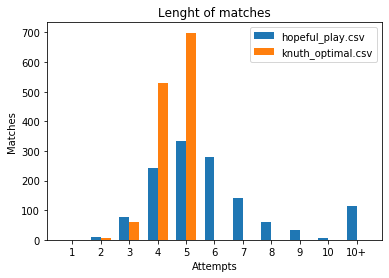

In [33]:
%matplotlib inline
my_bar_plot(list(range(1,12)), matches_len_list, "Lenght of matches", "Attempts", "Matches", CSV_NAMES, tick_label=tick_label)

-----------------
## [Plot] Lenght average distribution
- TODO: match name on x axis

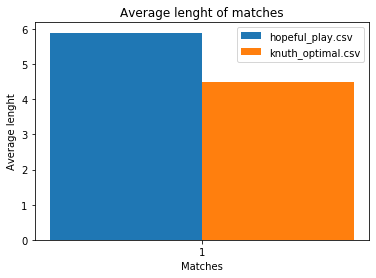

In [34]:
%matplotlib inline
matches_average_list_packed = [[el] for el in matches_average_list]
data_number = len(matches_average_list_packed)

my_bar_plot([1], matches_average_list_packed, "Average lenght of matches", "Matches", "Average lenght", CSV_NAMES)

-----------------
## [Plot] Cuts distribution

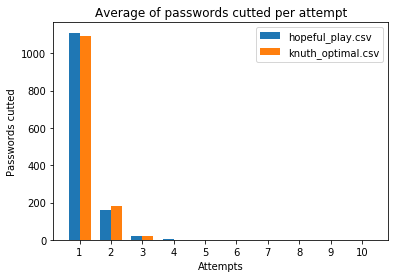

In [35]:
%matplotlib inline
my_bar_plot(list(range(1,11)), avg_cuts_list, "Average of passwords cutted per attempt", "Attempts", "Passwords cutted", CSV_NAMES)